## Get the Data

In [1]:
import nltk

In [2]:
import pandas as pd

We'll use **read_csv** and make note of the **sep** argument, we can also specify the desired column names by passing in a list of *names*.

In [3]:
messages = pd.read_csv('smsspamcollection', sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas!

In [4]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [5]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general. I encourage you to read up on the topic!

Let's make a new column to detect how long the text messages are:

In [6]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Data Visualization
Let's visualize this! Let's do the imports:

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

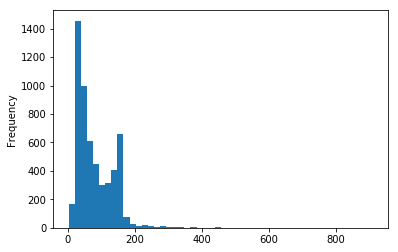

In [8]:
messages['length'].plot(bins=50, kind='hist') 

Play around with the bin size! Looks like text length may be a good feature to think about! Let's try to explain why the x-axis goes all the way to 1000ish, this must mean that there is some really long message!

In [9]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [10]:
messages[messages['length'] == 910]

,label,message,length
1085,ham,For me the love should start with attraction.i...,910


Woah! 910 characters, let's use masking to find this message:

In [11]:
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

## Text Pre-processing

Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.


In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

Let's create a function that will process the string in the message column, then we can just use **apply()** in pandas do process all the text in the DataFrame.

First removing punctuation. We can just take advantage of Python's built-in **string** library to get a quick list of all the possible punctuation:

In [12]:
import string

mess = 'Sample message! Notice: it has punctuation.'

# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

# Join the characters again to form the string.
nopunc = ''.join(nopunc)

In [13]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
nopunc

'Sample message Notice it has punctuation'

Now let's see how to remove stopwords. We can impot a list of english stopwords from NLTK (check the documentation for more languages and info).

In [15]:
from nltk.corpus import stopwords
stopwords.words('english')[0:10] # Show some stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [16]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [17]:
# Now just remove any stopwords
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [18]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

Now let's put both of these together in a function to apply it to our DataFrame later on:

In [19]:
from nltk.corpus import stopwords

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SAKSHI\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [21]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Here is the original DataFrame again:

In [22]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

Let's see an example output on on column:

**Note:**
We may get some warnings or errors for symbols we didn't account for or that weren't in Unicode (like a British pound symbol)

In [23]:
messages['message'].head(5)

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

In [24]:
# Check to make sure its working
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [25]:
# Show original dataframe
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


## Vectorization

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [28]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


In [35]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print('\n')

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2




In [ ]:
# this means that there are 7 unique words in message 4 and two of them appeared twice

Now let's see its vector representation:

Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [29]:
messages_bow = bow_transformer.transform(messages['message'])

In [30]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [31]:
from sklearn.feature_extraction.text import TfidfTransformer


In [32]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(messages_bow)
print(tfidf4)

  (0, 11163)	0.23026685592418913
  (0, 10965)	0.19073428545061483
  (0, 8917)	0.24704652376837993
  (0, 8336)	0.17046869292195632
  (0, 7668)	0.26403384065473806
  (0, 7555)	0.31253856260694546
  (0, 6937)	0.1834692413608692
  (0, 6906)	0.15158474664662352
  (0, 6217)	0.18915557732842803
  (0, 5769)	0.24984711892976424
  (0, 5218)	0.26870593862526665
  (0, 5217)	0.29835184088197164
  (0, 4653)	0.31253856260694546
  (0, 2060)	0.24203960256420656
  (0, 1483)	0.31253856260694546
  (0, 1110)	0.2882862016308418
  (1, 11072)	0.40061560982443056
  (1, 10698)	0.2063637481323008
  (1, 8590)	0.5043405901305854
  (1, 7701)	0.3767401070812794
  (1, 3064)	0.2911995411244838
  (1, 2451)	0.561988811929381
  (2, 11123)	0.19104387220509106
  (2, 11084)	0.15898145347176754
  (2, 10686)	0.13995540820792943
  :	:
  (5568, 6882)	0.31367469776242124
  (5568, 6691)	0.47781076401785183
  (5568, 6354)	0.5575721048646767
  (5568, 4880)	0.3853122086093004
  (5569, 10199)	0.520467167163554
  (5569, 8252)	0.432829

## Training a model

In [33]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


In [36]:
from sklearn.naive_bayes import MultinomialNB